# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import numpy as np
from glob import glob
import time

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline              

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torchsummary import summary
torch.random.manual_seed(1234)

# set flag to use GPU if CUDA is available
use_cuda = torch.cuda.is_available()
print(f'cuda available: {use_cuda}')

cuda available: True


In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


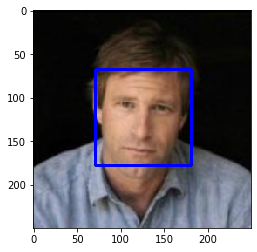

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__  The code correctly detects human faces in 96% of human images and incorrectly detects human faces in 18% of dog images.

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

true_positives = [face_detector(hf) for hf in human_files_short]
false_positives = [face_detector(df) for df in dog_files_short]
print(f'correctly detected {sum(true_positives)}% of human faces')
print(f'incorrectly detected human faces in {sum(false_positives)}% of dog images')

correctly detected 96% of human faces
incorrectly detected human faces in 18% of dog images


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
summary(VGG16, input_size=(3, 224 , 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [8]:
tfs = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def VGG16_predict(img_path, use_cuda=torch.cuda.is_available):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    img = Image.open(img_path)
    img = tfs(img)
    img = torch.unsqueeze(img, 0)
    if use_cuda:
        img = img.cuda()
    
    return VGG16(img).argmax()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):    
    return 151 <= VGG16_predict(img_path) <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
The code incorrectly detected dogs in 0% of human images and correctly detected dogs in 90% of dog images.

In [10]:
false_positives = [dog_detector(hf) for hf in human_files_short]
true_positives = [dog_detector(df) for df in dog_files_short]
print(f'incorrectly detected dogs in {sum(false_positives)}% of human images')
print(f'correctly detected dogs in {sum(true_positives)}% of dog images')

incorrectly detected dogs in 0% of human images
correctly detected dogs in 90% of dog images


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
# define transforms applied to images upon load
tfs = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

train_set = datasets.ImageFolder("/data/dogImages/train", transform=tfs)
valid_set = datasets.ImageFolder("/data/dogImages/valid", transform=tfs)
test_set = datasets.ImageFolder("/data/dogImages/test", transform=tfs)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=32)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=32)

loaders_scratch = {'train':train_loader, 'valid':valid_loader, 'test':test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 

I found that augmenting the data was essential to avoiding overfitting. I tried to add as many transformations as possible without affecting the "dog-like" quality of the photo. 

Normalization is required when working with models pretrained on ImageNet, but not necessarily for models trained from scratch. I found that the normalization above did not prevent me from reaching the 10% target accuracy when training from scratch and therefore used it for both training from scratch and transfer learning. 

I resize the images by cropping. As for why, short answer is because it was the simplest thing I could think of and it worked. It's possible one could achieve better performance by choosing a different resize technique but I did not explore this option.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:
# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(),
            #
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        
        self.ff_layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features=6272, out_features=133)
        )

    
    def forward(self, x):

        ## Define forward behavior
        x = self.conv_layers(x)
        x = x.view(-1, 6272)
        x = self.ff_layers(x)
        # for passing on to loss function, need to return scores, not probabilities

        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model_scratch.cuda()

In [14]:
summary(model_scratch,  input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,928
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I started with the VGG architecture as a basis. However, since we're starting from scratch and trying to solve an easier task compared to ImageNet (133 classes versus 1000), I felt optimistic that one could use fewer parameters and tried to strip away complexity from the model. In the end, I found a model with also 100x fewer parameters! I achieved this by not letting the convolutional layers grow as big as in VGG (max depth 128 versus max depth 256), and using a smaller fully connected head compared to VGG. 

I found that overfitting was a huge problem when training from scratch, and added some dropout layers to combat this.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [15]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=1e-4)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    model.zero_grad()
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        
        t0 = time.time()
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            model.zero_grad()
            loss = criterion(model(data), target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            print(f'\rBatch {batch_idx}, Loss {loss.data}', end=' ')
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            loss = criterion(model(data), target)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        print(f'\nTime elasped: {(time.time() - t0)/60} minutes')
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model, save_path)
        
            
    # return trained model
    return model

In [17]:
# train the model
model_scratch = train(35, loaders_scratch, model_scratch, optimizer_scratch, 
    criterion_scratch, use_cuda, 'model_scratch.pt')

Batch 208, Loss 4.518813133239746  
Time elasped: 0.5955030719439188 minutes
Epoch: 1 	Training Loss: 5.318775 	Validation Loss: 4.534869


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/d

Batch 208, Loss 5.029521465301514  
Time elasped: 0.6129731138547262 minutes
Epoch: 2 	Training Loss: 4.651039 	Validation Loss: 4.388126
Batch 208, Loss 4.3347601890563965 
Time elasped: 0.5777990420659384 minutes
Epoch: 3 	Training Loss: 4.385433 	Validation Loss: 4.275351
Batch 208, Loss 4.139654636383057  
Time elasped: 0.6096386909484863 minutes
Epoch: 4 	Training Loss: 4.195987 	Validation Loss: 4.134423
Batch 208, Loss 4.113033294677734  
Time elasped: 0.6523700753847758 minutes
Epoch: 5 	Training Loss: 4.014509 	Validation Loss: 4.056650
Batch 208, Loss 3.8891220092773438 
Time elasped: 0.6553419987360637 minutes
Epoch: 6 	Training Loss: 3.842587 	Validation Loss: 3.974885
Batch 208, Loss 4.056234836578369  
Time elasped: 0.6337270418802897 minutes
Epoch: 7 	Training Loss: 3.707303 	Validation Loss: 3.962137
Batch 208, Loss 3.4154374599456787 
Time elasped: 0.646168573697408 minutes
Epoch: 8 	Training Loss: 3.552409 	Validation Loss: 3.809234
Batch 208, Loss 3.0793120861053467 

In [18]:
# load the model that got the best validation accuracy
model_scratch = torch.load('model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.907467
Test Accuracy: 28% (237/836)


In [21]:
del model_scratch
torch.cuda.empty_cache()

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [22]:
# define transforms applied to images upon load
tfs = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

train_set = datasets.ImageFolder("/data/dogImages/train", transform=tfs)
valid_set = datasets.ImageFolder("/data/dogImages/valid", transform=tfs)
test_set = datasets.ImageFolder("/data/dogImages/test", transform=tfs)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=32)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=32)

loaders_transfer = {'train':train_loader, 'valid':valid_loader, 'test':test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [23]:
# define the CNN architecture
class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()
        self.pretrained = models.resnet50(pretrained=True)
        self.linear = nn.Linear(in_features=1000, out_features=133)
    
    def forward(self, x):

        x = self.pretrained(x)
        x = self.linear(x)

        return x


# instantiate the CNN
model_transfer = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
The pretrained model is already a good dog detector, as we saw above, and is even aware of many of the dog breeds we wish to classify. All it needs is an extra layer that compresses the output to the correct number of classes and the ability to retrain some of the end layers. 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [24]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=1e-5)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:
# train the model
model_transfer = train(15, loaders_transfer, model_transfer,
    optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Batch 208, Loss 2.967824697494507  
Time elasped: 0.7202523032824198 minutes
Epoch: 1 	Training Loss: 4.025055 	Validation Loss: 2.623910


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Bottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AdaptiveAvgPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Batch 208, Loss 1.47124445438385 4 
Time elasped: 0.7203515609105428 minutes
Epoch: 2 	Training Loss: 2.044116 	Validation Loss: 1.397355
Batch 208, Loss 0.9633695483207703 
Time elasped: 0.7391111890474955 minutes
Epoch: 3 	Training Loss: 1.215899 	Validation Loss: 0.909327
Batch 208, Loss 1.0454778671264648 
Time elasped: 0.7111777424812317 minutes
Epoch: 4 	Training Loss: 0.826874 	Validation Loss: 0.710996
Batch 208, Loss 0.5756801962852478  
Time elasped: 0.7278105815251669 minutes
Epoch: 5 	Training Loss: 0.613628 	Validation Loss: 0.578227
Batch 208, Loss 0.286678284406662 3 
Time elasped: 0.7717457572619121 minutes
Epoch: 6 	Training Loss: 0.478603 	Validation Loss: 0.522184
Batch 208, Loss 0.3555314242839813  
Time elasped: 0.7293259104092916 minutes
Epoch: 7 	Training Loss: 0.372198 	Validation Loss: 0.458374
Batch 208, Loss 0.33878442645072937 
Time elasped: 0.6899865786234538 minutes
Epoch: 8 	Training Loss: 0.306051 	Validation Loss: 0.445296
Batch 208, Loss 0.247099712491

In [26]:
# load the model that got the best validation accuracy
model_transfer = torch.load('model_transfer.pt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.379796
Test Accuracy: 88% (742/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [28]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_set.classes]

tfs = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_breed_transfer(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    img = Image.open(img_path)
    img = tfs(img)
    img = torch.unsqueeze(img, 0)
    if torch.cuda.is_available:
        img = img.cuda()
    
    return class_names[model_transfer(img).argmax()]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [29]:
def run_app(img_path):
    
    is_dog = dog_detector(img_path)
    is_human = face_detector(img_path)
    
    if (is_dog and is_human) or (not is_dog and not is_human):
        print('Error: either both dog and human or neither dog nor human.')
        return 
    
    breed = predict_breed_transfer(img_path)
    beast = "dog" if is_dog else "human"
    print(f'Hello {beast}! You look like a {breed}.')
    
    img = cv2.imread(file)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
    return

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

If I had more time, I would have built a better face detector. The haar cascades face detector thought 18% of dog pictures contained a human face. On the one hand that makes sense, since superficially dog faces and human faces are similar -- they both have a mouth, two eyes, a nose, two ears, etc. However, I think you could build a model to do better. The dog detector, for instance, is trained to detect specific dog breeds, and because of its specificity, it never mistakes a human for a dog. 

Other than that, we could have perhaps squeezed an extra few drops of accuracy out of the breed classification by trying other pretrained models as a starting point or training for longer or by combining models and building a stacked model.  At 89% test accuracy though, I think it's pretty good!

Hello human! You look like a Wirehaired pointing griffon.


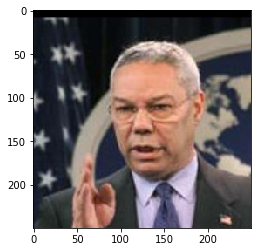

Hello human! You look like a Pharaoh hound.


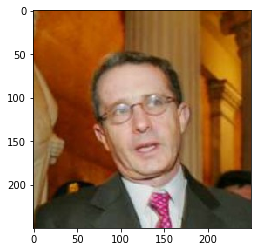

Hello human! You look like a Great dane.


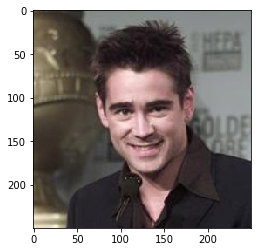

Hello dog! You look like a Boston terrier.


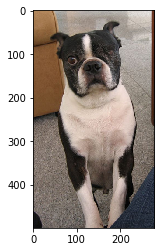

Error: either both dog and human or neither dog nor human.
Hello dog! You look like a American foxhound.


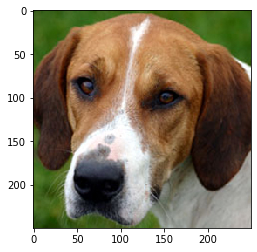

In [30]:
np.random.shuffle(dog_files)
np.random.shuffle(human_files)

for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)